# Notebook generador de gráficas geográficas de tiendas ANTAD

Localizar geográficamente las tiendas afiliadas a la ANTAD en 2024. 

In [15]:
# Importar librerías 
    # Manejo de información en arreglos y dataframes
import numpy as np
import pandas as pd
    # Manejo de información geoespacial
import geopandas as gpd
import pyproj
from shapely.ops import transform
    # Manejo de expresiones regulares
import re
    # Manejo de unicode
from unidecode import unidecode
    # Manejo de archivos y directorios del Sistema Operativo
import os
    # Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# Definimos directorios automatizados
CURRENT_PATH = os.getcwd()
GENERAL_PATH = os.path.dirname(CURRENT_PATH)
DATA_PATH = os.path.join(GENERAL_PATH, "data")

In [3]:
# Leemos los datos

data1 = gpd.read_file(os.path.join(DATA_PATH, "denue_00_46111_shp", "denue_inegi_46111_.shp"))
data2 = gpd.read_file(os.path.join(DATA_PATH, "denue_00_46112-46311_shp","denue_inegi_46112-46311_.shp"))
data3 = gpd.read_file(os.path.join(DATA_PATH, "denue_00_46321-46531_shp","denue_inegi_46321-46531_.shp"))
data4 = gpd.read_file(os.path.join(DATA_PATH, "denue_00_46591-46911_shp","denue_inegi_46591-46911_.shp"))

antad = pd.read_csv(os.path.join(DATA_PATH, "empresas_antad.csv"))
dataframesList = [data1, data2, data3, data4]
data = gpd.GeoDataFrame(pd.concat(dataframesList, ignore_index=True), crs=dataframesList[0].crs)

In [9]:
def limpia_nombre(name):
    if name is not None:
        name = name.replace("R. L.", "RL")
        # Quitamos acentos
        name = unidecode(name)
        # Limpiamos en general
        name = re.sub(r"[^\w\s&]", "", name)
        # Quitamos puntos
        name = name.replace('.', '').upper()
        name = name.strip()
    return name

# Limpiamos el nombre del segundo data set
antad['raz_social'] = antad['Razón social'].apply(limpia_nombre)
data['raz_social'] = data['raz_social'].apply(limpia_nombre)

# Hacemos el join
merge = antad.merge(data, 
                      on='raz_social', 
                      how='inner')

In [18]:
merge_gdf = gpd.GeoDataFrame(merge, crs = data1.crs)

In [14]:
# Extraemos un dataset geográfico sobre los estados mexicanos
mexico_path = os.path.join(DATA_PATH, 'Mexico')
mexico = gpd.read_file(os.path.join(mexico_path, 'mexican-states.shp'))
print(mexico.crs)

EPSG:4326


c:\Users\Memit\OneDrive - INSTITUTO TECNOLOGICO AUTONOMO DE MEXICO\Documentos\ITAM\Dataton\dataton_env\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: c:\Users\Memit\OneDrive - INSTITUTO TECNOLOGICO AUTONOMO DE MEXICO\Documentos\ITAM\Dataton\RONDA_FINAL\VERSION_LOCAL\data\Mexico\mexican-states.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Index(['Especializada', 'Autoservicio', 'Departamental'], dtype='object', name='Formato')

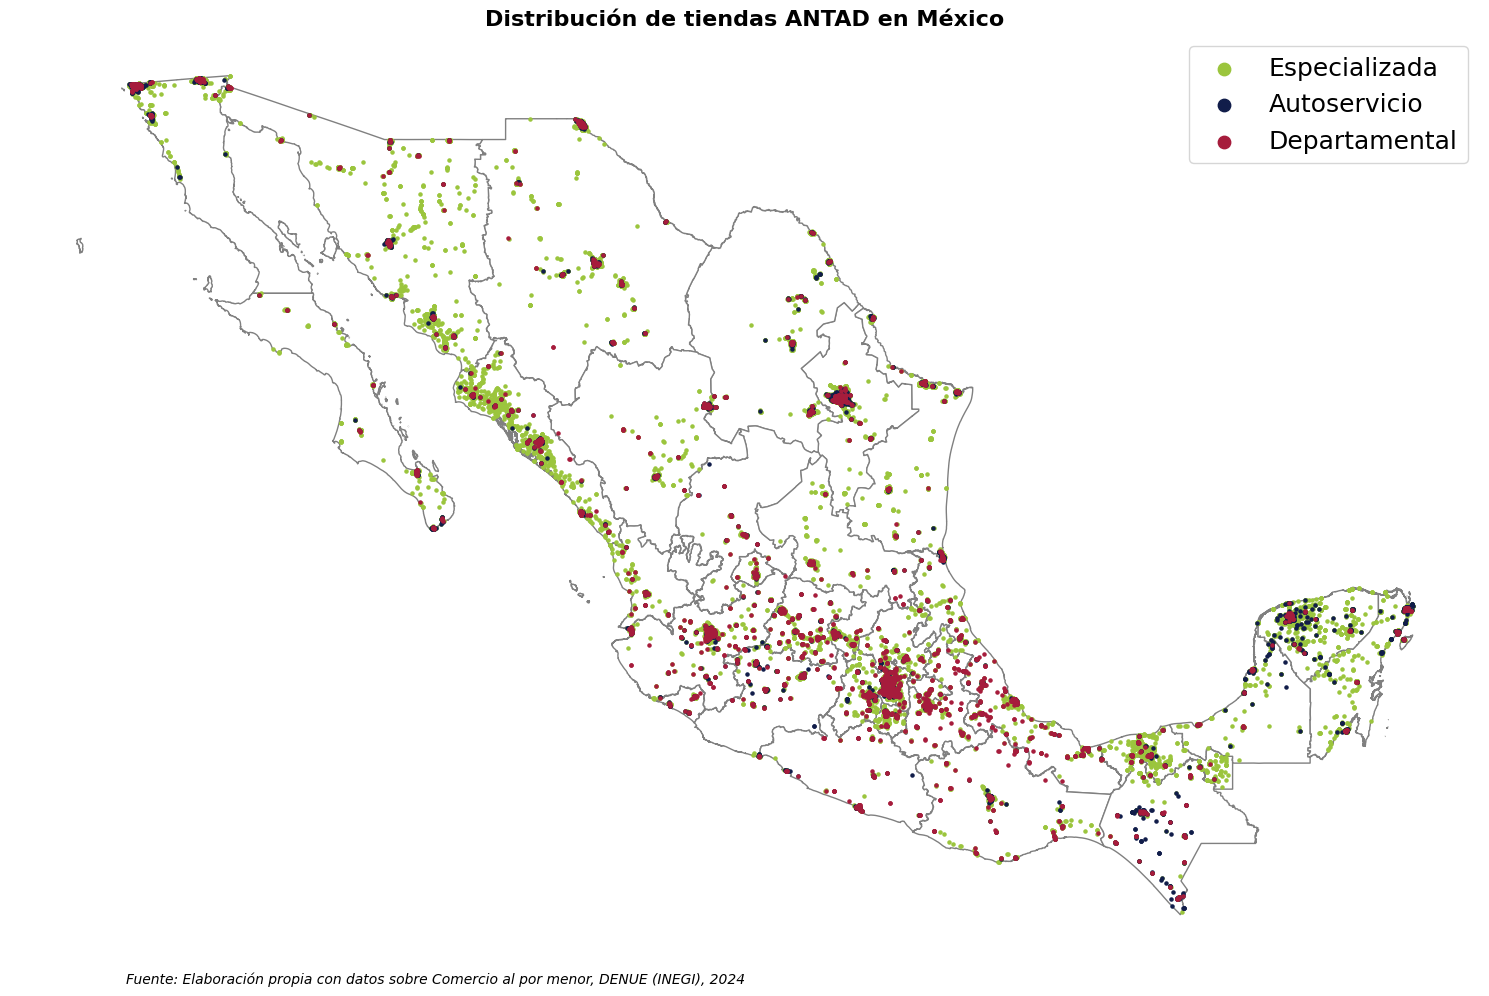

In [40]:
# Visualización para farmacias en méxico según su categoría (cuentan con minisuper o no)
fig, ax = plt.subplots(figsize=(15,10))

    # Primero graficamos la capa de los estados mexicanos
mexico.plot(ax=ax, color = 'white', edgecolor='gray')

    # Guardamos las categorías de farmacias según minisuper o no
tiendas = merge_gdf['Formato'].value_counts(sort=True, ascending=False).index.to_numpy()

# Verde, Azul, Rojo
colors = ["#9BC53D", "#111D4A", "#A61C3C"]

# Agregamos cada capa según la categoría a la que pertenecen
for category, color in zip(tiendas, colors):
    subset = merge_gdf[merge_gdf['Formato'] == category]
    subset.plot(ax=ax, color=color, markersize=5, label=category)

ax.set_title("Distribución de tiendas ANTAD en México", fontsize=16, fontweight='bold')
plt.figtext(0.5, 0.01, "Fuente: Elaboración propia con datos sobre Comercio al por menor, DENUE (INEGI), 2024", 
            ha="right", fontsize=10, style='italic')
ax.set_axis_off()
plt.legend(fontsize=18, markerscale = 4)
plt.tight_layout()
plt.show()

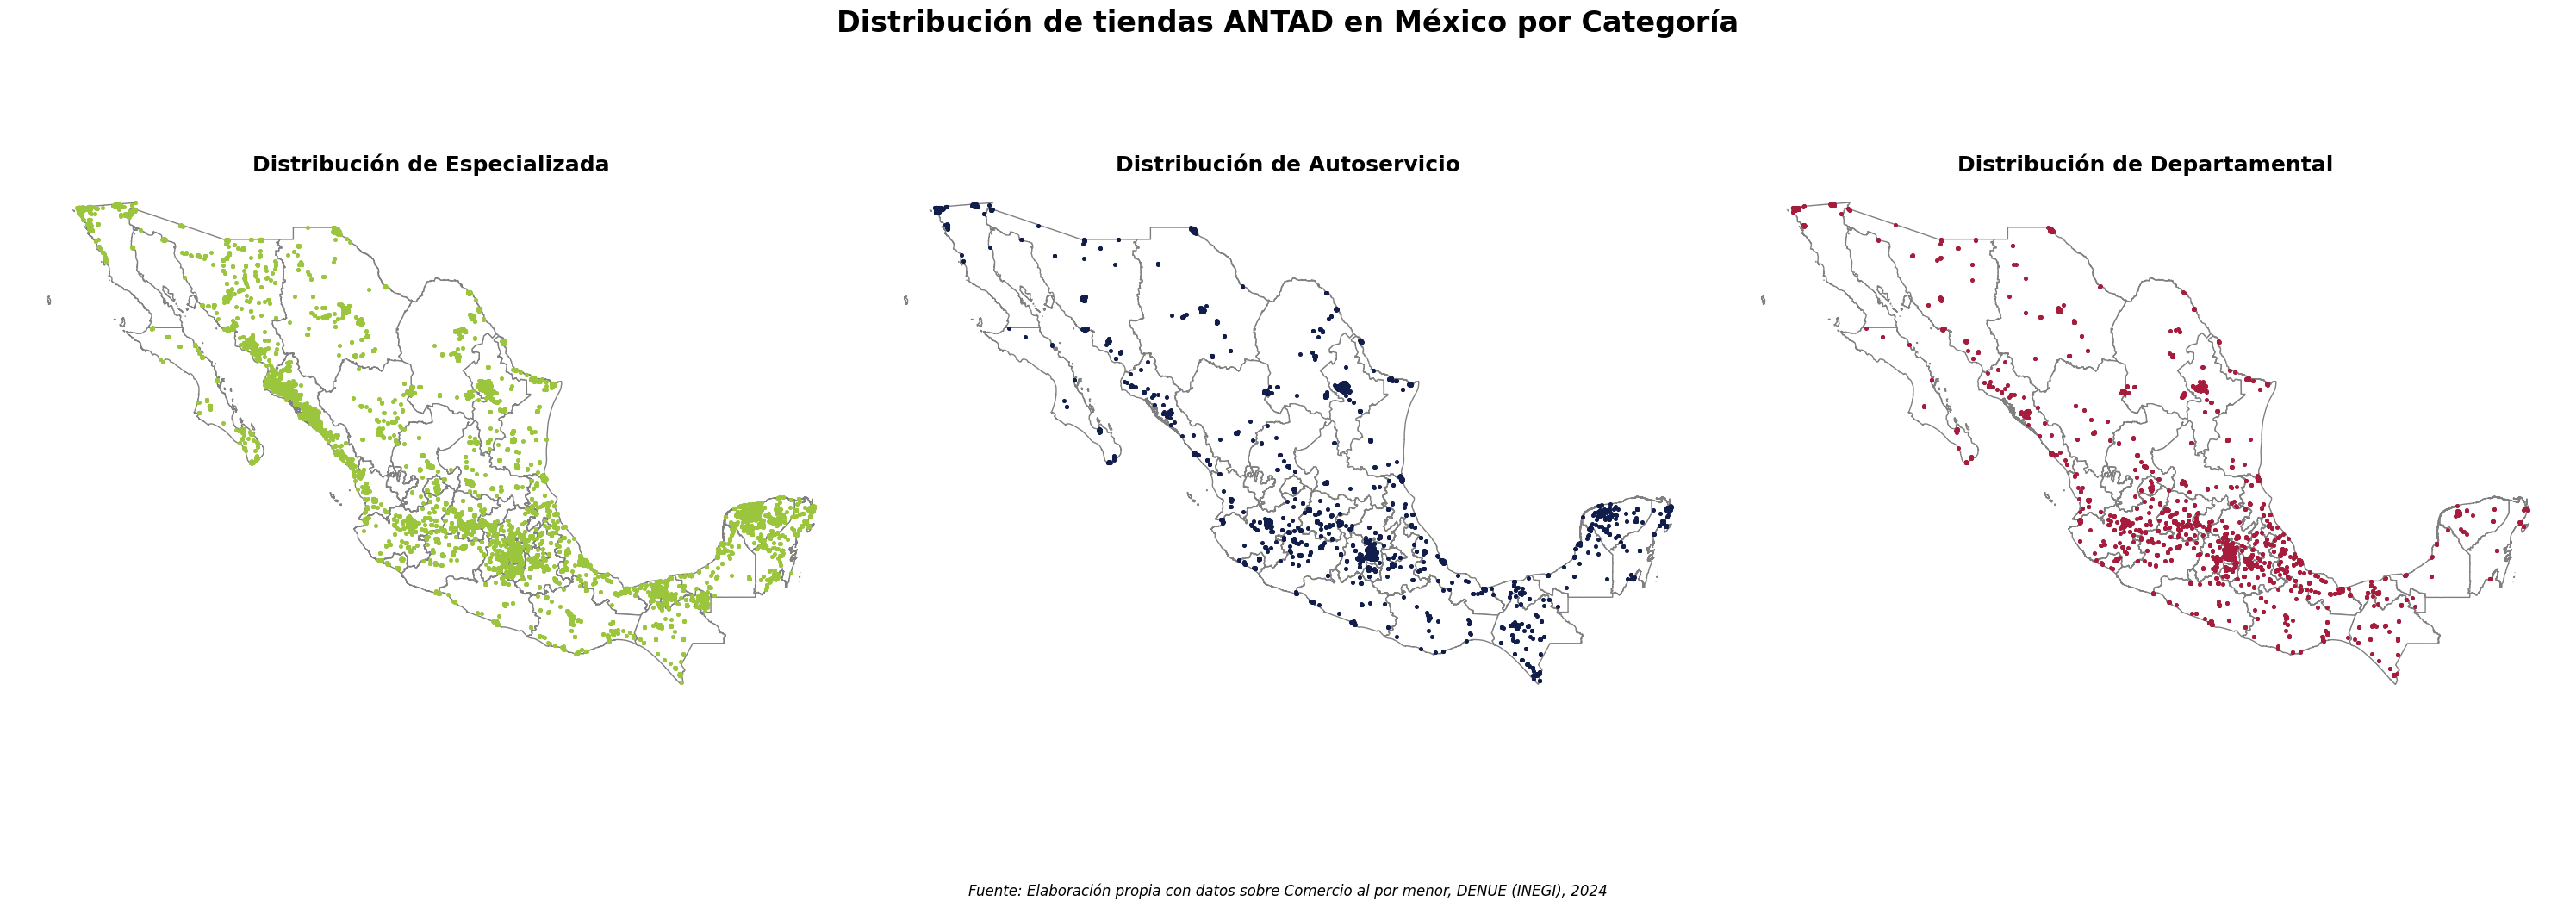

In [47]:
# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Create a map for each category
for idx, (category, color) in enumerate(zip(tiendas, colors)):
    # Select the current subplot
    ax = axes[idx]
    
    # Plot base map (estados mexicanos)
    mexico.plot(ax=ax, color='white', edgecolor='gray')
    
    # Plot stores for current category
    subset = merge_gdf[merge_gdf['Formato'] == category]
    subset.plot(ax=ax, color=color, markersize=7, label=category)
    
    # Customize each subplot
    ax.set_title(f"Distribución de {category}", fontsize=18, fontweight='bold')
    ax.set_axis_off()

# Add overall figure title and source
plt.suptitle("Distribución de tiendas ANTAD en México por Categoría", 
             fontsize=24, fontweight='bold')
plt.figtext(0.5, -0.05, 
            "Fuente: Elaboración propia con datos sobre Comercio al por menor, DENUE (INEGI), 2024",
            ha="center", fontsize=12, style='italic')

plt.tight_layout()
plt.show()